In [19]:
%matplotlib inline

In [20]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import numpy as np
import sklearn


from sklearn.preprocessing import normalize
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.cross_validation import StratifiedKFold, StratifiedShuffleSplit

from imblearn.over_sampling import  SMOTE 

import warnings
warnings.filterwarnings('ignore')

import utils_veolia


In [21]:
input_raw, output_raw, input_submission = utils_veolia.load_data()
#input_preprocessed = utils_veolia.preprocess(input_raw, year=2014, more_features=False)
#input_train, output_train, input_test, output_test = utils_veolia.split_train_test_Kfold(output_raw, input_preprocessed, year=2014)

In [22]:
#input_train_duplicate, output_train_duplicate = utils_veolia.data_augmentation_basic(input_train, output_train, repetitions = 6)

# Classification

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [67]:
RFC = RandomForestClassifier(n_estimators=10, max_depth=20)
GBC = GradientBoostingClassifier(loss='exponential',n_estimators=5, max_depth=10, learning_rate=10)
ABC = AdaBoostClassifier(n_estimators=5, algorithm='SAMME.R')
svm = SVC()
logreg = LogisticRegression()
classifier = ABC

In [48]:
n_estimators_list = [3,5,10,20]
algos = ['SAMME.R', 'SAMME']

In [74]:
over_sampling = True
_and = False
_or = False
triple_and = False
predict_proba = True
smote = True
test_size = 0.6
scores_list = []
n_estimators_list = [3]
algos = ['SAMME']
list(itertools.product(n_estimators_list, algos))

results_cross_val = {}
    
for tupl in list(itertools.product(n_estimators_list, algos)):
    classifier = AdaBoostClassifier(n_estimators=tupl[0], algorithm=tupl[1])
    #classifier = SVC(probability=True)
    for i in range(10):
        YEAR = 2014
        input_preprocessed = utils_veolia.preprocess(input_raw, year=YEAR, _and=_and, _or=_or, triple_and=triple_and)
        input_train, output_train, input_test, output_test = utils_veolia.split_train_test_stratified_shuffle(output_raw, input_preprocessed, test_size,YEAR)
        
        if over_sampling:
            if smote:
                # SMOTE over sampling
                sm = SMOTE(random_state=42)
                input_train_duplicate, output_train_duplicate = sm.fit_sample(input_train, output_train[str(YEAR)])
            else:
                # simple duplication
                input_train_duplicate, output_train_duplicate = utils_veolia.data_augmentation_basic(input_train, output_train, year = YEAR,repetitions = 8)
        else:
            input_train_duplicate = input_train
            output_train_duplicate = output_train[str(YEAR)]
            
        X_train = input_train_duplicate
        #utils_veolia.print_repartition(output_train_duplicate)
        Y_train = output_train_duplicate

        X_test = input_test
        Y_test_2014 = utils_veolia.preprocess_output(output_test, year = YEAR)

        rdm_1 = classifier
        rdm_1.fit(X_train, Y_train)
        
        if predict_proba:
            y_pred_2014 = rdm_1.predict_proba(X_test)
            y_pred_2014 = y_pred_2014[:,1]
        else:
            y_pred_2014 = rdm_1.predict(X_test)
            print(classification_report(Y_test_2014,y_pred_2014))

        YEAR = 2015
        input_preprocessed = utils_veolia.preprocess(input_raw, year=YEAR, _and=_and, _or=_or, triple_and=triple_and)
        input_train, output_train, input_test, output_test = utils_veolia.split_train_test_stratified_shuffle(output_raw, input_preprocessed, test_size=test_size, year=YEAR)

        if over_sampling:
            if smote:
                # SMOTE over sampling
                sm = SMOTE(random_state=42)
                input_train_duplicate, output_train_duplicate = sm.fit_sample(input_train, output_train[str(YEAR)])
            else:
                # simple duplication
                input_train_duplicate, output_train_duplicate = utils_veolia.data_augmentation_basic(input_train, output_train, year = YEAR,repetitions = 8)
        else:
            input_train_duplicate = input_train
            output_train_duplicate = output_train[str(YEAR)]
            
        X_train = input_train_duplicate
        #utils_veolia.print_repartition(output_train_duplicate)
        Y_train = output_train_duplicate

        X_test = input_test
        Y_test_2015 = utils_veolia.preprocess_output(output_test, year = YEAR)

        rdm_2 = classifier
        rdm_2.fit(X_train, Y_train)

        if predict_proba:
            y_pred_2015 = rdm_1.predict_proba(X_test)
            y_pred_2015 = y_pred_2015[:,1]
        else:
            y_pred_2015 = rdm_1.predict(X_test)
            print(classification_report(Y_test_2015,y_pred_2015))

        pred = np.array([y_pred_2014,y_pred_2015]).T
        true = np.array([Y_test_2014,Y_test_2015]).T

        scores_list += [utils_veolia.score_function(true, pred)]

    #print scores_list
    print np.mean(scores_list)
    print np.var(scores_list)
    results_cross_val[tupl] = (np.mean(scores_list), np.var(scores_list))

0.802695504633
0.000385730192034


In [73]:
print np.mean(scores_list)
print np.var(scores_list)

0.854225555406
0.000890690455597


In [57]:
results_cross_val_no_ov = results_cross_val

In [53]:
results_cross_val_with_duplicate= results_cross_val

In [51]:
results_cross_val_with_smote = results_cross_val

In [59]:
mean_nos = [k[0] for k in results_cross_val_with_duplicate.values()]
variance_nos = [k[1] for k in results_cross_val_with_duplicate.values()]
mean_s = [k[0] for k in results_cross_val_with_smote.values()]
variance_s = [k[1] for k in results_cross_val_with_smote.values()]
mean_noov = [k[0] for k in results_cross_val_no_ov.values()]
variance_noov = [k[1] for k in results_cross_val_no_ov.values()]

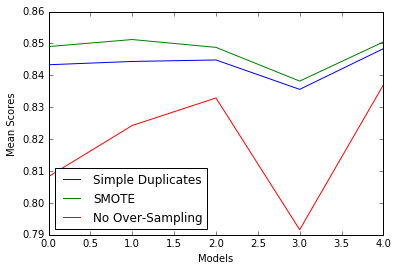

In [63]:
plt.figure()
plt.plot(np.array(mean_nos))
plt.plot(np.array(mean_s))
plt.plot(np.array(mean_noov))
plt.legend(['Simple Duplicates', 'SMOTE', 'No Over-Sampling'], loc='best')
plt.ylabel('Mean Scores')
plt.xlabel('Models')
plt.savefig('../plots/means2.png')
plt.show()

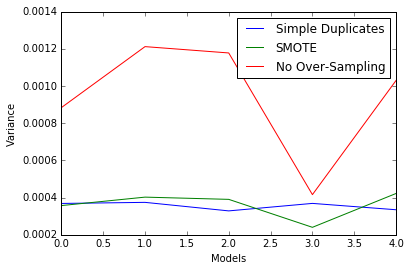

In [65]:
plt.figure()
plt.plot(variance_nos)
plt.plot(variance_s)
plt.plot(variance_noov)
plt.legend(['Simple Duplicates', 'SMOTE', 'No Over-Sampling'], loc='best')
plt.ylabel('Variance')
plt.xlabel('Models')
plt.savefig('../plots/variance2.png')
plt.show()

In [105]:
# Predictions for the submission data
input_submission_2014 = utils_veolia.preprocess(input_submission, year=2014, more_features=True)
sub_1 = rdm_1.predict_proba(input_submission_2014)
input_submission_2015 = utils_veolia.preprocess(input_submission, year=2015, more_features=True)
sub_2 = rdm_2.predict_proba(input_submission_2015)

In [106]:
# Submission formating
submission = pd.DataFrame()
submission['Id'] = input_submission.index.tolist()
submission['2014'] = sub_1[:,1]
submission['2015'] = sub_2[:,1]
submission = submission.set_index('Id')
submission.to_csv('../submissions/data_augmentation_ABC_new.csv',index=True,sep=';')

In [108]:
from sklearn.externals import joblib
joblib.dump(rdm_1, '../model/winning_ABC_2014.pkl')
joblib.dump(rdm_2, '../model/winning_ABC_2015.pkl') 

['../model/winning_ABC_2015.pkl']